In [408]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import statsmodels.api as sm

In [436]:
salary = pd.read_csv('full_salary.csv').iloc[:, 1:]
other = pd.read_csv('NBA_done.csv').iloc[:, :]
other.Year = other.Year.astype(str)

In [412]:
year_dict = {}
posi_dict = {}
star_dict = {}
year_df = pd.DataFrame()
avg_df = pd.DataFrame()
for i in range(2012, 2019):
    year_dict[f'{i}'] = salary[salary.Year == i]
    star_dict[f'{i}'] = pd.DataFrame()
    for j in ['C', 'F', 'G']:
        posi_dict[f'{i}_{j}'] = salary[(salary.Year == i) & (salary.Position == j)]

for key in year_dict.keys():
    temp_df = year_dict[key]
    first10 = temp_df.Salary.quantile(q = 0.9)
    median = temp_df.Salary.quantile(q = 0.5)
    last10 = temp_df.Salary.quantile(q = 0.1)
    temp_year = pd.DataFrame(dict(Name = ['10%', '50%', '90%'], Position = key[5:], Team = 'League',
                                 Salary = [first10, median, last10], Year = key[:4]))
    year_df = pd.concat([year_df, temp_year], axis = 0).reset_index(drop = True)
        
for key in posi_dict.keys():
    temp_df = posi_dict[key]
    first10 = temp_df.Salary.quantile(q = 0.9)
    median = temp_df.Salary.quantile(q = 0.5)
    last10 = temp_df.Salary.quantile(q = 0.1)
    temp_avg = pd.DataFrame(dict(Name = ['10%', '50%', '90%'], Position = key[5:], Team = 'League',
                                 Salary = [first10, median, last10], Year = key[:4]))
    avg_df = pd.concat([avg_df, temp_avg], axis = 0).reset_index(drop = True)

    star_mask = (temp_df.groupby('Team').Salary.nlargest(4) > first10).astype(int)
    star_num = star_mask.groupby('Team').sum()
    star_df = pd.DataFrame(star_num)
    star_df.columns = [f'{key[5:]}_star']
    star_dict[key[:4]] = pd.concat([star_dict[key[:4]], star_df], axis = 1)
    if key[5:] == 'G':
        star_dict[key[:4]]['CxG'] = star_dict[key[:4]].C_star*star_dict[key[:4]].G_star
        star_dict[key[:4]]['CxF'] = star_dict[key[:4]].C_star*star_dict[key[:4]].F_star
        star_dict[key[:4]]['FxG'] = star_dict[key[:4]].F_star*star_dict[key[:4]].G_star
        star_dict[key[:4]]['CxFxG'] = star_dict[key[:4]].C_star*star_dict[key[:4]].F_star*star_dict[key[:4]].G_star
        star_dict[key[:4]]['Year'] = key[:4]

year_df.Position = 'all'
done_salary = pd.concat([salary, year_df, avg_df], axis = 0).reset_index(drop = True)
allstar_df = pd.DataFrame()
for i in star_dict.keys():
    allstar_df = pd.concat([allstar_df, star_dict[i]])
allstar_df = allstar_df.reset_index()
allstar_df = allstar_df.drop(index = [29, 119, 120, 121, 122]).reset_index(drop = True)
allstar_df = allstar_df.rename(columns = {'index': 'Team'})

In [495]:
reg_df = allstar_df.merge(other[['Team', 'Year', 'W']], on = ['Year', 'Team'], how = 'inner')
X = reg_df.iloc[:, 1:8]
Y = reg_df.W
exog = sm.add_constant(X, prepend = False)
model = sm.OLS(Y, exog)
result = model.fit()
coef_df = pd.DataFrame(result.summary().tables[1])
coef_df = coef_df.set_index(0)
coef_df = coef_df.T
col_name = coef_df.columns[0]
coef_df = coef_df.set_index(col_name).T
coef_df

,coef,std err,t,P>|t|,[0.025,0.975]
0,,,,,,
C_star,7.3008,3.706,1.970,0.051,-0.017,14.619
F_star,5.7434,2.054,2.796,0.006,1.688,9.799
G_star,4.9161,1.625,3.025,0.003,1.707,8.126
CxG,-4.9642,3.902,-1.272,0.205,-12.668,2.740
CxF,-3.0439,3.810,-0.799,0.426,-10.568,4.480
FxG,-0.5535,1.762,-0.314,0.754,-4.032,2.925
CxFxG,4.6065,4.318,1.067,0.288,-3.920,13.133
const,31.7001,2.024,15.661,0.000,27.703,35.697


Text(0.5, 0, 'Salary (quantile)')

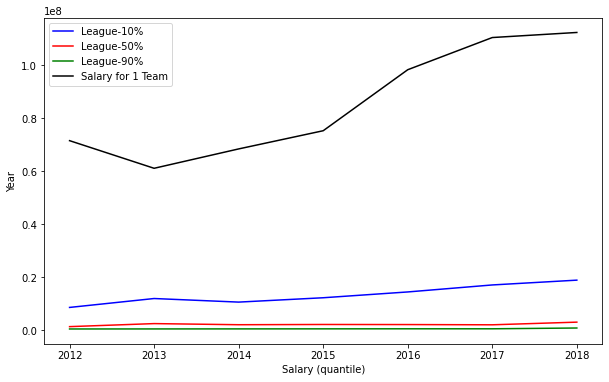

In [214]:
A10 = year_df[year_df.Name == '10%']
A50 = year_df[year_df.Name == '50%']
A90 = year_df[year_df.Name == '90%']
Aall = (salary.groupby('Year').sum()/30).Salary
plt.figure(figsize = (10, 6))
plt.plot(A10.Year, A10.Salary, 'b-', label = 'League-10%')
plt.plot(A50.Year, A50.Salary, 'r-', label = 'League-50%')
plt.plot(A90.Year, A90.Salary, 'g-', label = 'League-90%')
plt.plot(A10.Year, Aall, 'k-', label = 'Salary for 1 Team')
plt.legend()
plt.ylabel('Year')
plt.xlabel('Salary (quantile)')

Text(0, 0.5, 'Salary (quantile)')

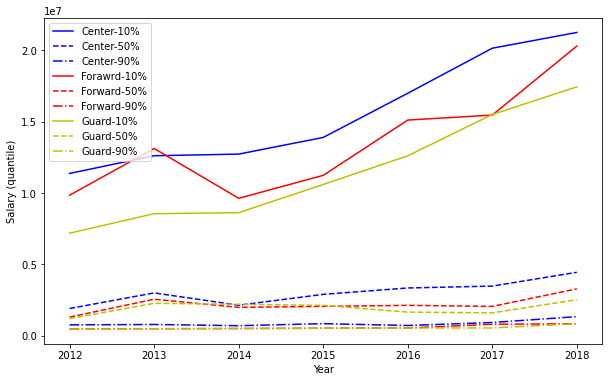

In [178]:
C10 = avg_df[(avg_df.Position == 'C') & (avg_df.Name == '10%')]
C50 = avg_df[(avg_df.Position == 'C') & (avg_df.Name == '50%')]
C90 = avg_df[(avg_df.Position == 'C') & (avg_df.Name == '90%')]
F10 = avg_df[(avg_df.Position == 'F') & (avg_df.Name == '10%')]
F50 = avg_df[(avg_df.Position == 'F') & (avg_df.Name == '50%')]
F90 = avg_df[(avg_df.Position == 'F') & (avg_df.Name == '90%')]
G10 = avg_df[(avg_df.Position == 'G') & (avg_df.Name == '10%')]
G50 = avg_df[(avg_df.Position == 'G') & (avg_df.Name == '50%')]
G90 = avg_df[(avg_df.Position == 'G') & (avg_df.Name == '90%')]

plt.figure(figsize = (10, 6))
plt.plot(C10.Year, C10.Salary, 'b-', label = 'Center-10%')
plt.plot(C50.Year, C50.Salary, 'b--', label = 'Center-50%')
plt.plot(C90.Year, C90.Salary, 'b-.', label = 'Center-90%')
plt.plot(F10.Year, F10.Salary, 'r-', label = 'Forawrd-10%')
plt.plot(F50.Year, F50.Salary, 'r--', label = 'Forward-50%')
plt.plot(F90.Year, F90.Salary, 'r-.', label = 'Forward-90%')
plt.plot(G10.Year, G10.Salary, 'y-', label = 'Guard-10%')
plt.plot(G50.Year, G50.Salary, 'y--', label = 'Guard-50%')
plt.plot(G90.Year, G90.Salary, 'y-.', label = 'Guard-90%')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Salary (quantile)')